In [0]:
dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/df_prophet.csv

In [0]:
!pip install mlflow
!pip install prophet

  Using cached mlflow-2.16.2-py3-none-any.whl (26.7 MB)
  Using cached SQLAlchemy-2.0.35-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached graphene-3.3-py2.py3-none-any.whl (128 kB)
  Using cached docker-7.1.0-py3-none-any.whl (147 kB)
  Using cached flask-3.0.3-py3-none-any.whl (101 kB)
  Using cached gunicorn-23.0.0-py3-none-any.whl (85 kB)
  Using cached Markdown-3.7-py3-none-any.whl (106 kB)
  Using cached alembic-1.13.3-py3-none-any.whl (233 kB)
  Using cached mlflow_skinny-2.16.2-py3-none-any.whl (5.6 MB)
  Using cached sqlparse-0.5.1-py3-none-any.whl (44 kB)
  Using cached opentelemetry_api-1.27.0-py3-none-any.whl (63 kB)
  Using cached opentelemetry_sdk-1.27.0-py3-none-any.whl (110 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)
  Using cached importlib_metadata-8.5.0-py3-none-any.whl (26 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (737 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl 

In [0]:
import pandas as pd
from prophet import Prophet
from pyspark.sql import SparkSession
import mlflow
import mlflow.sklearn


In [0]:
spark = SparkSession.builder \
    .appName("DemandForecasting") \
    .getOrCreate()


In [0]:
df = spark.read.csv("dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/df_prophet.csv", header=True, inferSchema=True)


In [0]:
# Convert to Pandas DataFrame
pandas_df = df.toPandas()

In [0]:
pandas_df['LastSaleDate'] = pd.to_datetime(pandas_df['LastSaleDate'])  # Convert LastSaleDate to datetime
df_prophet = pandas_df[['LastSaleDate', 'Sales']].rename(columns={'LastSaleDate': 'ds', 'Sales': 'y'})


In [0]:
print(df_prophet.isnull().sum())


ds    0
y     0
dtype: int64


In [0]:
train_size = int(len(df_prophet) * 0.8)
train_df = df_prophet[:train_size]
test_df = df_prophet[train_size:]


In [0]:
model = Prophet()
model.fit(train_df)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_vwnixqe/t267bcy8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_vwnixqe/rai6l7q_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/local_disk0/.ephemeral_nfs/envs/pythonEnv-e7541940-375a-43d3-b339-a7351c6414e9/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25132', 'data', 'file=/tmp/tmp_vwnixqe/t267bcy8.json', 'init=/tmp/tmp_vwnixqe/rai6l7q_.json', 'output', 'file=/tmp/tmp_vwnixqe/prophet_modelcacwt89b/prophet_model-20241007173815.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start proc

Out[12]: <prophet.forecaster.Prophet at 0x7efdc499f1c0>

In [0]:
future = model.make_future_dataframe(periods=len(test_df), freq='M')


In [0]:
forecast = model.predict(future)

Mean Absolute Error: 11.028870501358872


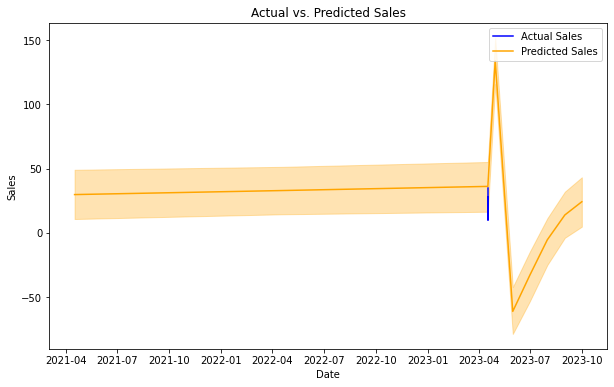

In [0]:
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(test_df, on='ds', how='left')
predictions['mae'] = abs(predictions['y'] - predictions['yhat'])
print(f'Mean Absolute Error: {predictions["mae"].mean()}')
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predictions['ds'], predictions['y'], label='Actual Sales', color='blue')
plt.plot(predictions['ds'], predictions['yhat'], label='Predicted Sales', color='orange')
plt.fill_between(predictions['ds'], predictions['yhat_lower'], predictions['yhat_upper'], color='orange', alpha=0.3)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Sales')
plt.show()


In [0]:
with mlflow.start_run():
    mlflow.prophet.log_model(model, "prophet_model")
    mlflow.log_params({"n_changepoints": model.n_changepoints})

2024/10/07 17:39:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

2024/10/07 17:39:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run hilarious-seal-109 at: https://community.cloud.databricks.com/ml/experiments/4498943658609964/runs/81bcae5e66334f39b2e12c5a3c293ad6.
2024/10/07 17:39:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/4498943658609964.
